# UPT DEMO

In [145]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tesspy import Tessellation

## Crash Dynamic

In [234]:
drone_profile={
    'mass': 1,
    'g': 9.81,
    'cd': 0.02,
    'cl': 0,
    'flight_lv': 400
    }


In [286]:
from pyproj import Proj
import pandas as pd
import geopandas as gpd
import numpy as np

#from . import ballistic_model, glide_model

class base_impact_model:
    def __init__(self, model, ac_profile, crs, n_sampling = 1000):
        self.model_type = model
        self.crs = crs
        self.n_sampling = n_sampling
        self.ac_profile = ac_profile
        self.model_func = self.get_function()
    
    def get_function(self):
        crash_func={
            "ballistic":ballistic_model,
            "glide": None,
        }
        return(crash_func[self.model_type]) 
    
    def run_model(self):
        self.impact_point = self.model_func(self.n_sampling, self.ac_profile)
        self.binning()
        self.array_to_gpd()
        self.meter_to_lonlat()
        self.pd_to_gpd()
        
        return(self.mask_gdf)
    
    def run_unbinned_model(self):
        self.impact_point = self.model_func(self.n_sampling, self.ac_profile)
        self.binning()
        return(self.historgram )
    
    def binning(self):
        bins = [np.linspace(self.impact_point.min(), self.impact_point.max(), 10), np.linspace(self.impact_point.min(), self.impact_point.max(), 10)]
        histogram, x_bin, y_bin  = np.histogram2d(self.impact_point[0], self.impact_point[1], bins=bins)
        self.historgram = histogram
        
        self.n_point_map = {}
        self.locmap_map = {}
        self.n_point_map.setdefault("N_points", [])
        self.locmap_map.setdefault("x_loc", [])
        self.locmap_map.setdefault("y_loc", [])
        for ith, _ in enumerate(histogram):
            for jth, point in enumerate(histogram[ith]):
                self.n_point_map['N_points'].append(point)
                self.locmap_map['x_loc'].append(x_bin[ith])
                self.locmap_map['y_loc'].append(y_bin[jth])
                
    def array_to_gpd(self):
        self.n_point_df = pd.DataFrame(self.n_point_map)
        self.locmap_df = pd.DataFrame(self.locmap_map)
        self.mask_df = self.n_point_df.join(self.locmap_df)
        
    def meter_to_lonlat(self):
        p = Proj(projparams = self.crs, peserve_units=False)
        self.mask_df['x_loc'], self.mask_df['y_loc'] = p(self.mask_df['x_loc'], self.mask_df['y_loc'], inverse=True)
        
    def pd_to_gpd(self):
        self.mask_gdf = gpd.GeoDataFrame(self.mask_df.copy(), geometry=gpd.points_from_xy(self.mask_df['x_loc'], self.mask_df['y_loc']))
        self.mask_gdf.drop(['x_loc','y_loc'], axis=1, inplace = True)

        #Dividde N_point by sample size
        self.mask_gdf['N_points'] = self.mask_gdf['N_points']/self.n_sampling


In [287]:
ballistic_model = base_impact_model("ballistic", drone_profile,depok_school.crs)

In [288]:
gdf_mask_hist = ballistic_model.run_unbinned_model()

In [281]:
print(gdf_mask_hist)

None


In [267]:
gdf_mask = ballistic_model.run_model()

In [272]:
gdf_mask

,N_points,geometry
0,0.000,POINT (-113.293 -113.293)
1,0.002,POINT (-113.293 -88.001)
2,0.010,POINT (-113.293 -62.709)
3,0.032,POINT (-113.293 -37.417)
4,0.025,POINT (-113.293 -12.125)
...,...,...
76,0.026,POINT (89.043 -12.125)
77,0.036,POINT (89.043 13.167)
78,0.007,POINT (89.043 38.459)
79,0.000,POINT (89.043 63.751)


<AxesSubplot: >

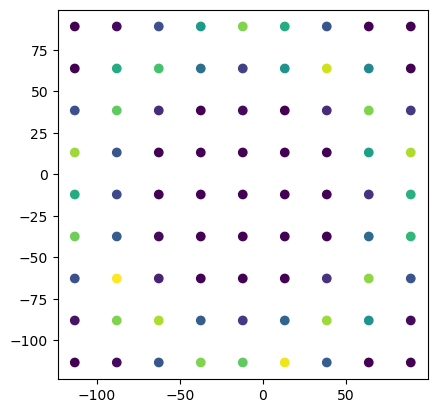

In [271]:
gdf_mask.plot(column="N_points")

In [285]:
def ballistic_model(n_sampling, ac_profile):
    sample_points = np.random.normal(15, 3, size=(n_sampling))
    mass = ac_profile['mass']
    g = ac_profile['g']
    cd = ac_profile['cd']
    flight_lv = ac_profile['flight_lv']
    
    gamma = np.sqrt(mass*g/cd)
    log2 = np.log(2)
    cd_z = cd*flight_lv
    m_per_c = mass/cd
    m_gamma = mass*gamma
    
    #Warning! Mathematically untested
    def ballistic(v_sample):
        point_list = []
        for v in v_sample:
            angle_degree = np.radians(np.random.uniform(0,360))
            ballistic_x = m_per_c*np.log(1+(v*((mass*log2+cd_z)/(m_gamma))))
            ballistic_y = m_per_c*np.log(1+(v*((mass*log2+cd_z)/(m_gamma))))
            
            radial_ballistic_func_x = lambda angle :ballistic_x*np.cos(angle)
            radial_ballistic_func_y = lambda angle :ballistic_y*np.sin(angle)
            x_point = radial_ballistic_func_x(angle_degree)
            y_point = radial_ballistic_func_y(angle_degree)
            point_list.append((x_point,y_point))
        return (np.array(point_list))

    crash_point = ballistic(sample_points)
    crash_point = np.column_stack((crash_point))
    return(crash_point)

In [214]:
dist = ballistic_model(1000,aircraft_profile)

In [215]:
bins = [np.linspace(dist.min(), dist.max(), 10), np.linspace(dist.min(), dist.max(), 10)]
histogram, x_bin, y_bin  = np.histogram2d(dist[0], dist[1], bins=bins)


n_point_map = {}
locmap_map = {}
n_point_map.setdefault("N_points", [])
locmap_map.setdefault("x_loc", [])
locmap_map.setdefault("y_loc", [])
for ith, _ in enumerate(histogram):
    for jth, point in enumerate(histogram[ith]):
        n_point_map['N_points'].append(point)
        locmap_map['x_loc'].append(x_bin[ith])
        locmap_map['y_loc'].append(y_bin[jth])
        

In [216]:
import pandas as pd

n_point_df = pd.DataFrame(n_point_map)
locmap_df = pd.DataFrame(locmap_map)
mask_df = n_point_df.join(locmap_df)

In [217]:
from pyproj import Proj
p = Proj(proj='utm',zone=48,ellps='WGS84', preserve_units=False)
mask_df['x_loc'], mask_df['y_loc'] = p(mask_df['x_loc'], mask_df['y_loc'], inverse=True)

In [225]:
mask_df

,N_points,x_loc,y_loc,geometry
0,0.0,100.510212,-0.001051,POINT (100.51021 -0.00105)
1,0.0,100.510212,-0.000817,POINT (100.51021 -0.00082)
2,8.0,100.510212,-0.000584,POINT (100.51021 -0.00058)
3,21.0,100.510212,-0.000350,POINT (100.51021 -0.00035)
4,34.0,100.510212,-0.000117,POINT (100.51021 -0.00012)
...,...,...,...,...
76,24.0,100.512068,-0.000117,POINT (100.51207 -0.00012)
77,24.0,100.512068,0.000117,POINT (100.51207 0.00012)
78,6.0,100.512068,0.000350,POINT (100.51207 0.00035)
79,0.0,100.512068,0.000584,POINT (100.51207 0.00058)


In [221]:
import geopandas as gpd
mask_gdf = gpd.GeoDataFrame(mask_df.copy(), geometry=gpd.points_from_xy(mask_df['x_loc'], mask_df['y_loc']))
mask_gdf.drop(['x_loc','y_loc'], axis=1, inplace = True)

#Dividde N_point by sample size
mask_gdf['N_points'] = mask_gdf['N_points']/1000

<AxesSubplot: >

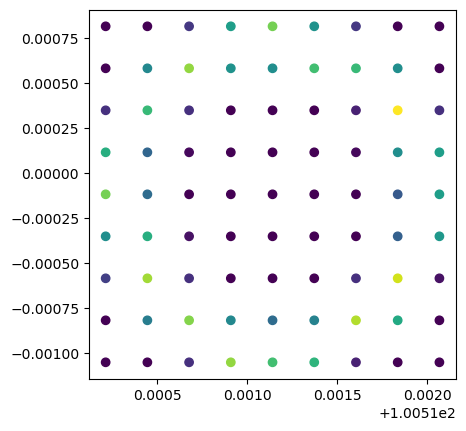

In [224]:
mask_gdf.plot(column='N_points')

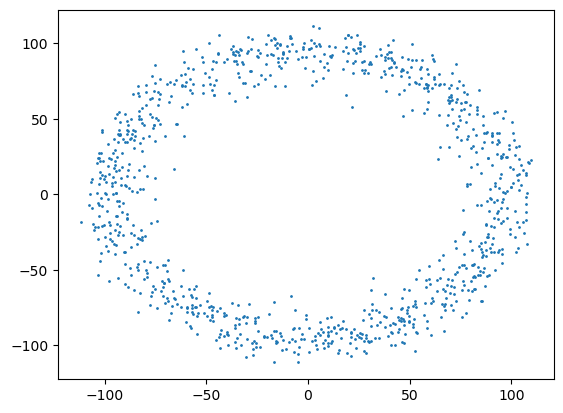

In [157]:
from matplotlib import pyplot as plt 
plt.scatter(dist[0],dist[1],s=1)

### Basic Setup

loaded
loaded
loaded gdf


D:\TUGAS SEKOLAH\College\Smst 7, Odd 2023\UAV PATH PLANNER\upt\postprocessor\a_star.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.centroids = np.column_stack((gdf.to_crs(self.crs).centroid.x, gdf.to_crs(self.crs).centroid.y))
D:\TUGAS SEKOLAH\College\Smst 7, Odd 2023\UAV PATH PLANNER\upt\postprocessor\a_star.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.centroids = np.column_stack((gdf.to_crs(self.crs).centroid.x, gdf.to_crs(self.crs).centroid.y))


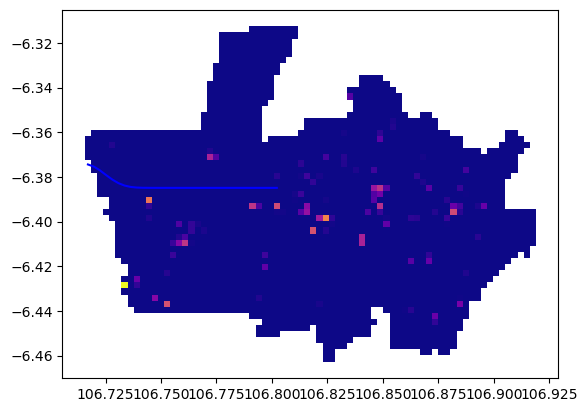

In [230]:
from upt.preprocessor.features_of_interest import FeatureOfInterest as foi
from upt.postprocessor.a_star import AStar
from upt.utils.geo_utils import line_smoothing as lsp

import matplotlib.pyplot as plt


depok_obj = foi('Depok',crs=3857,zoom_level=17)
depok_school = depok_obj.area_of_interest({'amenity':'school'})


depok_star = AStar(depok_school,'area',crs=depok_school.crs)
depok_path = depok_star.run_instance(3,1000)
way_marker = depok_star.create_line()
way_path = lsp(way_marker[:,0],way_marker[:,1],)

ax = depok_school.plot(column="area",cmap='plasma')
plt.plot(way_path[:,0], way_path[:,1],color='blue')

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

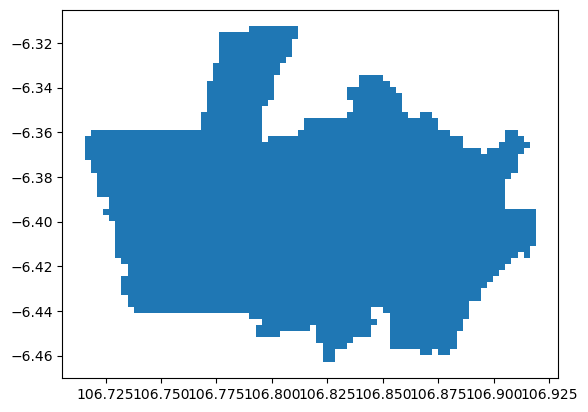

In [28]:
depok_school.plot()

In [3]:
zen = np.random.normal(15, 3, size=(1000,2))
mass = 1
g = 9.81
c = 0.025
flight_lv  = 400

gamma = np.sqrt(mass*g/c)
log2 = np.log(2)
cy = c*flight_lv
mperc = mass/c
mgamma = mass*gamma
def ballistic(vx):
    x = mperc*np.log(1+(vx*((mass*log2+cy)/(mgamma))))
    y = mperc*np.log(1+(vx*((mass*log2+cy)/(mgamma))))
    return (y)
                        
vec_ball = np.vectorize(ballistic)
x_dist = vec_ball(zen)
plt.scatter(x_dist[0],x_dist[1])

NameError: name 'plt' is not defined

In [120]:
from shapely.geometry import Point, Polygon, box
from tesspy.tessellation_functions import get_squares_polyfill

In [84]:
p_list = list(map(lambda point:Point(point),x_dist))
idx = np.arange(x_dist.shape[0])
point_gpd = gpd.GeoDataFrame({'Name':idx,'geometry':p_list})

<AxesSubplot: >

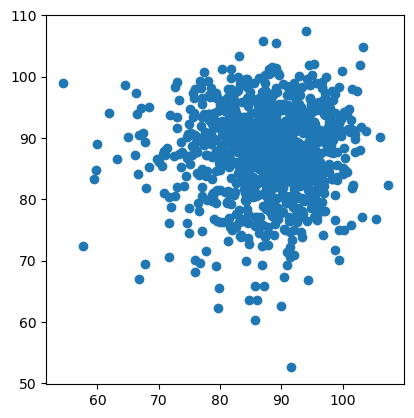

In [100]:
point_gpd.plot()

In [200]:
sqr_poly = box(*point_gpd.total_bounds)

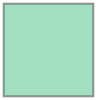

In [201]:
sqr_poly

In [202]:
sqr_df = gpd.GeoDataFrame({'Name':[1],'geometry':sqr_poly})

In [215]:
sqr_tessel = get_squares_polyfill(sqr_df,21)

<AxesSubplot: >

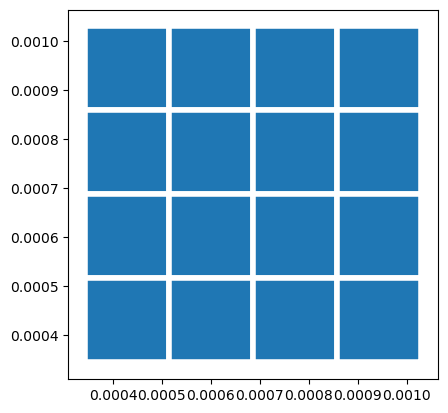

In [216]:
sqr_tessel.plot(lw=4,edgecolor='w')

In [149]:
sqr_tessel['id']=sqr_tessel.index
data_merged = gpd.sjoin(area_overlay, sqr_tessel, how="inner",predicate='within')
area_df = data_merged.groupby('id')['idx'].agg('sum')
final_gpd = pd.merge(square_grid, area_df, on='id', how='outer', indicator=False)

NameError: name 'square_grid' is not defined

In [150]:
sqr_tessel['id']=sqr_tessel.index

In [165]:
sqr_tessel

,geometry,quadkey,id
0,"POLYGON ((67.50000 82.67628, 67.50000 85.05113...",1010,0
1,"POLYGON ((67.50000 79.17133, 67.50000 82.67628...",1012,1
2,"POLYGON ((67.50000 74.01954, 67.50000 79.17133...",1030,2
3,"POLYGON ((67.50000 66.51326, 67.50000 74.01954...",1032,3
4,"POLYGON ((67.50000 55.77657, 67.50000 66.51326...",1210,4
5,"POLYGON ((67.50000 40.97990, 67.50000 55.77657...",1212,5
6,"POLYGON ((90.00000 82.67628, 90.00000 85.05113...",1011,6
7,"POLYGON ((90.00000 79.17133, 90.00000 82.67628...",1013,7
8,"POLYGON ((90.00000 74.01954, 90.00000 79.17133...",1031,8
9,"POLYGON ((90.00000 66.51326, 90.00000 74.01954...",1033,9


In [156]:
del sqr_tessel['children_id']

In [182]:
point_gpd.crs is None

True

In [183]:
sqr_tessel.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [186]:
point_gpd.crs

In [185]:
point_gpd.set_crs('EPSG:4326')

,Name,geometry
0,0,POINT (94.66609 90.54227)
1,1,POINT (87.60424 88.72771)
2,2,POINT (90.87327 85.24265)
3,3,POINT (86.95024 91.68280)
4,4,POINT (96.47418 81.51380)
...,...,...
995,995,POINT (97.32347 87.79448)
996,996,POINT (101.24292 90.90956)
997,997,POINT (90.51341 75.02474)
998,998,POINT (95.44983 80.63613)


In [191]:
point_gpd = point_gpd.to_crs('epsg:4326')
point_gpd.crs  

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [218]:
data_merged = gpd.sjoin(point_gpd, sqr_tessel, how="inner",predicate='within')

In [219]:
data_merged

,Name_left,geometry,index_right,Name_right,quadkey,children_id
0,0,POINT (0.00085 0.00081),9,1,122222222222222222122,"[1222222222222222221220, 122222222222222222122..."
1,1,POINT (0.00079 0.00080),9,1,122222222222222222122,"[1222222222222222221220, 122222222222222222122..."
2,2,POINT (0.00082 0.00077),9,1,122222222222222222122,"[1222222222222222221220, 122222222222222222122..."
3,3,POINT (0.00078 0.00082),9,1,122222222222222222122,"[1222222222222222221220, 122222222222222222122..."
5,5,POINT (0.00080 0.00072),9,1,122222222222222222122,"[1222222222222222221220, 122222222222222222122..."
...,...,...,...,...,...,...
492,492,POINT (0.00058 0.00089),4,1,122222222222222222031,"[1222222222222222220310, 122222222222222222031..."
907,907,POINT (0.00066 0.00089),4,1,122222222222222222031,"[1222222222222222220310, 122222222222222222031..."
915,915,POINT (0.00060 0.00087),4,1,122222222222222222031,"[1222222222222222220310, 122222222222222222031..."
944,944,POINT (0.00065 0.00088),4,1,122222222222222222031,"[1222222222222222220310, 122222222222222222031..."


<AxesSubplot: >

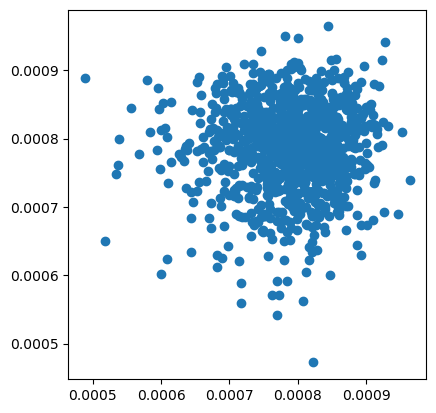

In [199]:
point_gpd.plot()

In [223]:
data_merged

,Name_left,geometry,index_right,Name_right,quadkey,children_id
0,0,POINT (0.00085 0.00081),9,1,122222222222222222122,"[1222222222222222221220, 122222222222222222122..."
1,1,POINT (0.00079 0.00080),9,1,122222222222222222122,"[1222222222222222221220, 122222222222222222122..."
2,2,POINT (0.00082 0.00077),9,1,122222222222222222122,"[1222222222222222221220, 122222222222222222122..."
3,3,POINT (0.00078 0.00082),9,1,122222222222222222122,"[1222222222222222221220, 122222222222222222122..."
5,5,POINT (0.00080 0.00072),9,1,122222222222222222122,"[1222222222222222221220, 122222222222222222122..."
...,...,...,...,...,...,...
492,492,POINT (0.00058 0.00089),4,1,122222222222222222031,"[1222222222222222220310, 122222222222222222031..."
907,907,POINT (0.00066 0.00089),4,1,122222222222222222031,"[1222222222222222220310, 122222222222222222031..."
915,915,POINT (0.00060 0.00087),4,1,122222222222222222031,"[1222222222222222220310, 122222222222222222031..."
944,944,POINT (0.00065 0.00088),4,1,122222222222222222031,"[1222222222222222220310, 122222222222222222031..."


In [224]:
area_df = data_merged.groupby('index_right').agg('sum')

C:\Users\MICKO\AppData\Local\Temp\ipykernel_8784\3631613288.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  area_df = data_merged.groupby('index_right').agg('sum')


In [238]:
sqr_tessel['id'] = sqr_tessel.index

In [243]:
final_gpd = pd.merge(sqr_tessel, area_df, on='id', how='outer', indicator=False)

In [242]:
area_df['id']=area_df.index

In [247]:
final_gpd.fillna(0,inplace=True)

<AxesSubplot: >

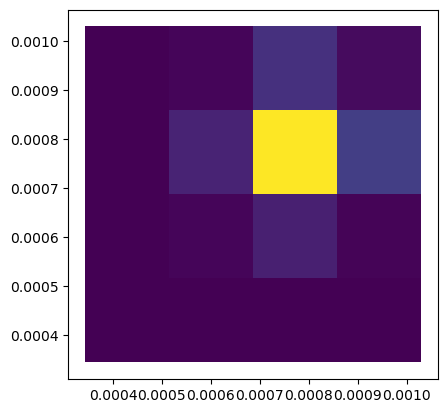

In [249]:
final_gpd.plot(column='Name_right')

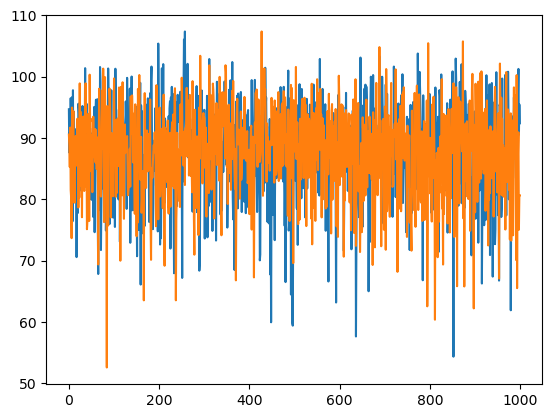

In [254]:
plt.plot(x_dist)

In [256]:
x_dist[1]

array([87.60423631, 88.72771254])

In [79]:
import numpy as np

# Generate some random data
points = np.random.rand(100, 2)

# Define the bins for the histogram
bins = [np.linspace(x_dist.min(), x_dist.max(), 10), np.linspace(x_dist.min(), x_dist.max(), 10)]

# Use the histogram2d function to create the histogram
histogram, a, b = np.histogram2d(x_dist[:,0], x_dist[:,1], bins=bins)

# Print the histogram
print(histogram)

[[  0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   1.   0.]
 [  0.   0.   0.   0.   1.   2.   3.   5.   0.]
 [  0.   0.   0.   0.   2.   6.  29.  15.   4.]
 [  0.   0.   0.   1.   3.  48.  73.  51.   5.]
 [  0.   1.   0.   3.  19.  74. 151. 121.  11.]
 [  0.   0.   0.   4.  12.  60. 121. 109.  22.]
 [  0.   0.   0.   0.   5.   5.  10.  19.   2.]]


In [76]:
b == a

array([False, False, False, False, False, False, False, False,  True])

In [37]:
r = histogram.flatten()

In [82]:
a[0]

35.64164918124939

In [120]:
d_map = {}
p_map = {}
d_map.setdefault("N_points", [])
p_map.setdefault("Lon", [])
p_map.setdefault("Lat", [])
for ith, o in enumerate(histogram):
    for jth, k in enumerate(histogram[ith]):
        d_map['N_points'].append(k)
        p_map['Lon'].append(a[ith])
        p_map['Lat'].append(b[jth])
        

In [40]:
histogram.shape

(9, 9)

In [121]:
import pandas as pd
p_dict = {'x':a,'y':b}
p_df = pd.DataFrame(p_map)
d_df = pd.DataFrame(d_map)
n_join = p_df.join(d_df)

In [127]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(n_join, geometry=gpd.points_from_xy(n_join['Lon'], n_join['Lat']))

In [134]:
gdf['N_points'].unique()

array([0.   , 0.001, 0.002, 0.003, 0.005, 0.006, 0.029, 0.015, 0.004,
       0.048, 0.073, 0.051, 0.019, 0.074, 0.151, 0.121, 0.011, 0.012,
       0.06 , 0.109, 0.022, 0.01 ])

In [132]:
gdf['N_points'] = gdf['N_points']/1000

<AxesSubplot: >

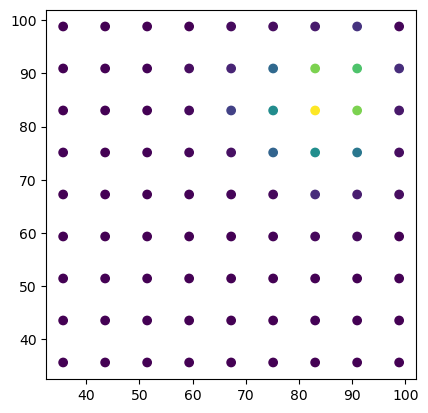

In [133]:
gdf.plot(column='N_points')

In [32]:
from sklearn.preprocessing import normalize
p_hist = histogram/1000

In [34]:
p_hist.max()

0.151

In [27]:
n_hist.max()

1.0

In [16]:
import numpy as np

# Generate some random data
points = np.random.rand(100, 2)

# Define the bins for the histogram
bins = [np.linspace(0, 1, 10), np.linspace(0, 1, 10)]

# Use the histogram2d function to create the histogram
histogram, _, _ = np.histogram2d(x_dist[:,0], x_dist[:,1], bins=bins)

# Print the histogram
print(histogram)

ValueError: `bins[0]` must be a scalar or 1d array

In [19]:
points.max()

0.9923744437047507

In [18]:
points[:,0]

array([6.37540851e-01, 3.94686984e-01, 4.68243439e-03, 7.20441833e-01,
       8.77463802e-01, 7.97703785e-01, 9.53441803e-01, 9.47677562e-01,
       1.04923380e-01, 5.99159505e-01, 2.95456218e-01, 1.02924592e-01,
       9.39914265e-01, 1.34062971e-01, 6.27185422e-01, 9.92374444e-01,
       2.42984200e-01, 9.03487767e-01, 3.11648770e-01, 2.22649533e-01,
       9.09983183e-02, 8.66809942e-01, 6.13657868e-01, 6.42464826e-01,
       7.48277697e-01, 3.21419228e-01, 6.95948599e-01, 4.87644950e-01,
       6.41573874e-01, 6.29439817e-01, 3.98237364e-01, 3.14047141e-01,
       2.51802526e-01, 9.49719957e-01, 5.54760349e-01, 1.45502157e-01,
       8.75134557e-01, 2.73467240e-01, 2.44473064e-01, 5.68898106e-01,
       6.95164131e-01, 8.78542518e-01, 1.35553692e-01, 5.94485308e-01,
       7.65409637e-01, 4.47526772e-01, 5.45862807e-01, 4.02433268e-01,
       3.77267676e-01, 6.28149862e-06, 1.62577809e-01, 8.31971056e-01,
       7.19263673e-01, 2.85301772e-01, 5.41411974e-01, 2.03886608e-01,
      

In [298]:
np.flip(histogram,axis=0)

array([[  0.,   0.,   0.,   2.,   4.,   2.,   9.,   2.,   2.],
       [  0.,   0.,   1.,   6.,  19.,  46.,  49.,  16.,   1.],
       [  1.,   1.,   4.,  18.,  50., 105.,  86.,  34.,   4.],
       [  0.,   3.,   4.,  21.,  44.,  92., 102.,  33.,   3.],
       [  0.,   1.,   2.,  12.,  21.,  36.,  52.,  25.,   1.],
       [  0.,   0.,   4.,   3.,   9.,  18.,  17.,   9.,   0.],
       [  0.,   0.,   2.,   0.,   1.,   7.,   7.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   4.,   1.,   1.,   0.],
       [  0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.]])

In [ ]:
from sklearn.preprocessing import normalize
zel = normalize(histogram)

In [301]:
zel =histogram/histogram.max()

In [303]:
histogram.max()

105.0

In [302]:
zel

array([[0.        , 0.        , 0.        , 0.00952381, 0.        ,
        0.        , 0.        , 0.00952381, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03809524, 0.00952381, 0.00952381, 0.        ],
       [0.        , 0.        , 0.01904762, 0.        , 0.00952381,
        0.06666667, 0.06666667, 0.00952381, 0.        ],
       [0.        , 0.        , 0.03809524, 0.02857143, 0.08571429,
        0.17142857, 0.16190476, 0.08571429, 0.        ],
       [0.        , 0.00952381, 0.01904762, 0.11428571, 0.2       ,
        0.34285714, 0.4952381 , 0.23809524, 0.00952381],
       [0.        , 0.02857143, 0.03809524, 0.2       , 0.41904762,
        0.87619048, 0.97142857, 0.31428571, 0.02857143],
       [0.00952381, 0.00952381, 0.03809524, 0.17142857, 0.47619048,
        1.        , 0.81904762, 0.32380952, 0.03809524],
       [0.        , 0.        , 0.00952381, 0.05714286, 0.18095238,
        0.43809524, 0.46666667, 0.15238095, 0.00952381],


In [278]:
help(np.histogram2d)

Help on function histogram2d in module numpy:

histogram2d(x, y, bins=10, range=None, normed=None, weights=None, density=None)
    Compute the bi-dimensional histogram of two data samples.
    
    Parameters
    ----------
    x : array_like, shape (N,)
        An array containing the x coordinates of the points to be
        histogrammed.
    y : array_like, shape (N,)
        An array containing the y coordinates of the points to be
        histogrammed.
    bins : int or array_like or [int, int] or [array, array], optional
        The bin specification:
    
          * If int, the number of bins for the two dimensions (nx=ny=bins).
          * If array_like, the bin edges for the two dimensions
            (x_edges=y_edges=bins).
          * If [int, int], the number of bins in each dimension
            (nx, ny = bins).
          * If [array, array], the bin edges in each dimension
            (x_edges, y_edges = bins).
          * A combination [int, array] or [array, int], wher

In [261]:
histogram.mean()

6.25

In [266]:
x_dist.shape

(1000, 2)

In [270]:
point_gpd.total_bounds

array([0.00048805, 0.00047223, 0.0009643 , 0.00096431])

In [274]:
x_dist[0].max()

94.66609204744822

In [15]:
import random

# Define the bounds of the simulation
x_min = 0
x_max = 100
y_min = 0
y_max = 100

# Number of iterations to run the simulation
num_iterations = 100000

# Counter to keep track of the number of points that fall within the region of interest
count = 0

# Run the simulation
for i in range(num_iterations):
  # Generate a random point within the bounds of the simulation
  x = random.uniform(x_min, x_max)
  y = random.uniform(y_min, y_max)

  # Check if the point falls within the region of interest
  if x**2 + y**2 <= 100:
    count += 1

# Calculate the probability that a randomly generated point falls within the region of interest
probability = count / num_iterations
print(probability)
print(count)

0.00765
765
